# Exercise 18

## Analyze class homeworks


In [1]:
import pandas as pd
import os
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.metrics import r2_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model, svm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import word_tokenize,sent_tokenize
from sklearn import metrics

import pickle

from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('E18.xlsx')
data.head()

,Sexo,T1,T2,T3,T4,T5,T6
0,H,Un científico de datos y un ingeniero de datos...,NaN,Los árboles de decisión es uno de los algoritm...,NaN,"En el documento ""Do We Need Hundreds of Classi...",Boosting builds models from individual so call...
1,H,Aunque los dos perfiles cuentan con habilidade...,Aunque el conceso no es total en el tema de ma...,NaN,En Machine Learing el propósito de los métodos...,El paper publicado en 2014 hace una evaluación...,Gradient Boosting ClassifierGradient Boosting ...
2,H,Python vs Stata. Analizar información es un pr...,En el marco del Machine Learning encontramos c...,Árbol de clasificación Como su nombre lo indic...,Este es un mecanismo que utiliza varios algori...,El paper analiza 179 clasificadores de 17 dife...,Gradient Boosting Classifier busca aprender de...
3,M,Los algoritmos de machine learning buscan pred...,Los algoritmos de machine learning buscan pred...,Los arboles de decisión pertenecen a los algor...,Consideremos el siguiente ejemplo: Una persona...,¿Se necesitan cientos de modelos para resolver...,NaN
4,H,Python vs R para análisis de datos. A pesar de...,Tipos de aprendizaje en Machine Learning. El M...,Tipos de árboles de decisión y aplicaciones. U...,La combinación de modelos o ensemble es un mod...,En el articulo se analizan cerca de 180 clasif...,XGBoosting vs GBoosting. A pesar de que el alg...


# Exercise 18.1

Analyze the writing patterns of each student

In [3]:
data.describe()

,Sexo,T1,T2,T3,T4,T5,T6
count,42,41,30,30,36,35,29
unique,2,41,30,30,36,35,29
top,H,Dos de las principales razones por las que a p...,Existen diferentes tipos de técnicas o algorit...,Los arboles de decisión son una técnica fundam...,"Los métodos de ensamble, también llamados méto...",Cuando se comienza a explorar en el mundo del ...,Tanto Gradient boosting Classifier como XGB Cl...
freq,34,1,1,1,1,1,1


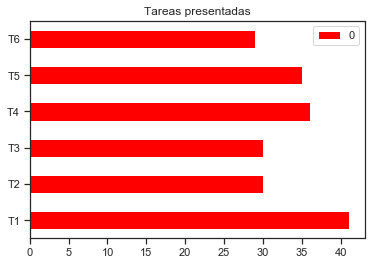

In [4]:
pd.DataFrame(data.loc[:, data.columns != 'Sexo'].notna().sum()).plot.barh(title ='Tareas presentadas',color='red')

In [5]:
#Primero hacemos un tratamiento de los NAN values para poder analizar los textos
data = data.replace(np.nan, '', regex=True)

In [6]:
#Concatenamos todos los textos para evaluar patrones

data['All_text'] = data['T1']+" "+data['T2']+" "+data['T3']+" "+data['T4']+" "+data['T5']+" "+data['T6']
data.head()

,Sexo,T1,T2,T3,T4,T5,T6,All_text
0,H,Un científico de datos y un ingeniero de datos...,,Los árboles de decisión es uno de los algoritm...,,"En el documento ""Do We Need Hundreds of Classi...",Boosting builds models from individual so call...,Un científico de datos y un ingeniero de datos...
1,H,Aunque los dos perfiles cuentan con habilidade...,Aunque el conceso no es total en el tema de ma...,,En Machine Learing el propósito de los métodos...,El paper publicado en 2014 hace una evaluación...,Gradient Boosting ClassifierGradient Boosting ...,Aunque los dos perfiles cuentan con habilidade...
2,H,Python vs Stata. Analizar información es un pr...,En el marco del Machine Learning encontramos c...,Árbol de clasificación Como su nombre lo indic...,Este es un mecanismo que utiliza varios algori...,El paper analiza 179 clasificadores de 17 dife...,Gradient Boosting Classifier busca aprender de...,Python vs Stata. Analizar información es un pr...
3,M,Los algoritmos de machine learning buscan pred...,Los algoritmos de machine learning buscan pred...,Los arboles de decisión pertenecen a los algor...,Consideremos el siguiente ejemplo: Una persona...,¿Se necesitan cientos de modelos para resolver...,,Los algoritmos de machine learning buscan pred...
4,H,Python vs R para análisis de datos. A pesar de...,Tipos de aprendizaje en Machine Learning. El M...,Tipos de árboles de decisión y aplicaciones. U...,La combinación de modelos o ensemble es un mod...,En el articulo se analizan cerca de 180 clasif...,XGBoosting vs GBoosting. A pesar de que el alg...,Python vs R para análisis de datos. A pesar de...


In [7]:
# Ahora creamos un vectorizar para evaluar la frecuencia de las palabras
vect = CountVectorizer()
X = data.All_text
X_vec = vect.fit_transform(X)

In [8]:
#Creamos un dataframe con la frecuencia y visualizamos las 20 palabras mas frecuentes
df=pd.DataFrame.from_dict(vect.vocabulary_, orient='index',columns=['Number'])
df.sort_values(by='Number', ascending=False).head(20)

,Number
útiles,5883
útil,5882
únicos,5881
único,5880
únicamente,5879
única,5878
últimos,5877
último,5876
últimas,5875
última,5874


# Exercise 18.2

Evaluate the similarities of the homeworks of the students

tip: https://github.com/orsinium/textdistance

In [9]:
import textdistance

In [10]:
def similarity(data):

    results = pd.DataFrame(0, index=data.index, columns=data.index)
        
    for i in results.index:    
        for j in results.index:
            results.loc[j,i]=textdistance.hamming.normalized_similarity(data.All_text[i],data.All_text[j])*100
                
            
    assert results.shape == (data.shape[0], data.shape[0])
    
    return results

In [11]:
data_similarity = similarity(data)

In [12]:
data_similarity.head(10)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,100.000000,5.069522,6.727697,5.656792,5.881337,5.112704,4.983159,6.331792,4.991795,6.742624,...,3.998618,7.035304,7.470421,5.587702,6.416203,5.598228,0.837723,6.284256,6.002245,5.138613
1,5.069522,100.000000,5.573062,6.141174,6.051142,6.492134,6.386476,4.960426,6.726931,5.509736,...,5.952101,5.427478,5.195705,6.395664,4.630489,3.965124,1.361822,4.895262,7.082667,7.690515
2,6.727697,5.573062,100.000000,6.437382,7.112632,5.104889,4.807779,6.613902,5.248942,6.487544,...,4.735752,6.490855,6.477312,5.870172,6.300247,5.487510,0.837310,6.216683,5.942199,5.582065
3,5.656792,6.141174,6.437382,100.000000,6.831934,5.817954,5.911792,5.454118,6.579085,5.730805,...,4.973413,6.261165,5.845168,6.798040,5.442177,4.712477,1.126056,5.601021,6.808466,6.235012
4,5.881337,6.051142,7.112632,6.831934,100.000000,5.729065,6.031622,6.347465,5.650986,6.096420,...,4.948272,6.337729,6.191548,6.226820,5.805504,5.072313,1.112629,5.473384,7.163771,5.973063
5,5.112704,6.492134,5.104889,5.817954,5.729065,100.000000,6.699629,4.341353,6.875369,4.718986,...,6.089378,4.908550,4.823346,5.897019,4.475881,3.709086,1.190024,4.076883,5.973333,6.595199
6,4.983159,6.386476,4.807779,5.911792,6.031622,6.699629,100.000000,4.882063,6.887183,4.735992,...,6.118665,4.678860,4.901282,6.265583,4.321274,3.854405,0.988875,3.934229,5.984000,6.397110
7,6.331792,4.960426,6.613902,5.454118,6.347465,4.341353,4.882063,100.000000,4.662644,6.276938,...,3.808479,6.723611,6.543374,5.508973,6.818182,6.470140,0.767965,7.035063,5.211190,4.490244
8,4.991795,6.726931,5.248942,6.579085,5.650986,6.875369,6.887183,4.662644,100.000000,4.974067,...,6.331955,5.163760,5.420852,6.070461,4.854669,4.248841,1.228588,4.166980,6.282667,7.212771
9,6.742624,5.509736,6.487544,5.730805,6.096420,4.718986,4.735992,6.276938,4.974067,100.000000,...,4.421393,7.235779,7.006207,5.815832,6.995980,6.387101,0.739733,6.652151,6.019896,5.679789


La matriz anterior nos muestra el porcentaje de similaridad entre todos los textos de los estudiantes, como se muestra en la diagonal, vemos coherencia en los resultados. 

In [13]:
def similarity_2(data):

    results = pd.DataFrame(0, index=data.index, columns=data.index)
        
    for i in results.index:    
        for j in results.index:
            results.loc[j,i]=textdistance.hamming(data.All_text[i],data.All_text[j])*100
                
            
    assert results.shape == (data.shape[0], data.shape[0])
    
    return results

In [14]:
data_similarity_2 = similarity_2(data)
data_similarity_2.head(10)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,1099200,1080000,1092400,1089800,1098700,1100200,1195300,1100100,1096800,...,1111600,1092800,1071400,1093200,1210600,1364200,1148200,1248200,1088400,1098400
1,1099200,0,1048800,900200,962600,796500,797400,1212800,794500,1111300,...,801100,1111700,1094800,863500,1233700,1387800,840200,1266700,871100,792200
2,1080000,1048800,0,1039200,1031700,1054000,1057300,1191700,1052400,1099800,...,1058100,1099200,1080000,1045500,1212100,1365800,1101400,1249100,1044700,1048700
3,1092400,900200,1039200,0,954600,903300,902400,1206500,896000,1108700,...,911400,1101900,1087300,893900,1223200,1377000,948300,1257300,893800,899300
4,1089800,962600,1031700,954600,0,965900,962800,1195100,966700,1104400,...,973900,1101000,1083300,960800,1218500,1371800,1013200,1259000,951200,963400
5,1098700,796500,1054000,903300,965900,0,754800,1220700,788300,1120600,...,741800,1117800,1099100,868100,1235700,1391500,780500,1277600,881500,801600
6,1100200,797400,1057300,902400,962800,754800,0,1213800,788200,1120400,...,759500,1120500,1098200,864700,1237700,1389400,801000,1279500,881400,803300
7,1195300,1212800,1191700,1206500,1195100,1220700,1213800,0,1216600,1196000,...,1227500,1190300,1192600,1205800,1205400,1351600,1266300,1238200,1209600,1218800
8,1100100,794500,1052400,896000,966700,788300,788200,1216600,0,1117600,...,792900,1114800,1092200,866500,1230800,1383700,836100,1276400,878600,796300
9,1096800,1111300,1099800,1108700,1104400,1120600,1120400,1196000,1117600,0,...,1124100,1091000,1093700,1107700,1203100,1352800,1167400,1243300,1105300,1109300


La matriz anterior muestra el número de cambios a realizar entre los textos, lo cual nos muestra la magnitud de las diferencias entre estudiantes.

Con las dos matrices se evidencia que no existe un alto porcentaje de similaridad entre los textos de los estudiantes.

# Exercise 18.3

Create a classifier to predict the sex of each student



In [15]:
#Primero creamos una nueva variable binaria para el género
data['Sexo_2'] = np.where(data['Sexo']=='H', 1, 0)
data.head()

,Sexo,T1,T2,T3,T4,T5,T6,All_text,Sexo_2
0,H,Un científico de datos y un ingeniero de datos...,,Los árboles de decisión es uno de los algoritm...,,"En el documento ""Do We Need Hundreds of Classi...",Boosting builds models from individual so call...,Un científico de datos y un ingeniero de datos...,1
1,H,Aunque los dos perfiles cuentan con habilidade...,Aunque el conceso no es total en el tema de ma...,,En Machine Learing el propósito de los métodos...,El paper publicado en 2014 hace una evaluación...,Gradient Boosting ClassifierGradient Boosting ...,Aunque los dos perfiles cuentan con habilidade...,1
2,H,Python vs Stata. Analizar información es un pr...,En el marco del Machine Learning encontramos c...,Árbol de clasificación Como su nombre lo indic...,Este es un mecanismo que utiliza varios algori...,El paper analiza 179 clasificadores de 17 dife...,Gradient Boosting Classifier busca aprender de...,Python vs Stata. Analizar información es un pr...,1
3,M,Los algoritmos de machine learning buscan pred...,Los algoritmos de machine learning buscan pred...,Los arboles de decisión pertenecen a los algor...,Consideremos el siguiente ejemplo: Una persona...,¿Se necesitan cientos de modelos para resolver...,,Los algoritmos de machine learning buscan pred...,0
4,H,Python vs R para análisis de datos. A pesar de...,Tipos de aprendizaje en Machine Learning. El M...,Tipos de árboles de decisión y aplicaciones. U...,La combinación de modelos o ensemble es un mod...,En el articulo se analizan cerca de 180 clasif...,XGBoosting vs GBoosting. A pesar de que el alg...,Python vs R para análisis de datos. A pesar de...,1


In [16]:
#Definimos X y y para el modelo y dividimos en train y test

X = data.drop(['Sexo','Sexo_2'], axis=1)
y = data['Sexo_2']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, random_state=42)

In [18]:
rf = RandomForestClassifier(n_jobs=-1,n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [19]:
y_pred = rf.predict(X_test)

In [20]:
metrics.accuracy_score(y_test,y_pred)

0.9090909090909091

In [21]:
pd.pivot_table(data, index='Sexo_2', aggfunc='count')

,All_text,Sexo,T1,T2,T3,T4,T5,T6
Sexo_2,,,,,,,,
0,8,8,8,8,8,8,8,8
1,34,34,34,34,34,34,34,34


In [22]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Tal como se observa en la tabla dinámica, hay desbalanceo de los géneros y el modelo está prediciendo únicamente género masculino. 